# Topic Modelling using LDA(Latent Dirichlet Allocation)

>LDA starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents.
>Reference: https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18



In [22]:
import pandas as pd
import os

abstracts_df = pd.read_csv(os.path.join('data', 'processed', 'abstracts.csv'))

In NLP tasks, usually, we need to normalize the texts before processing them. My normalization process consist in: converting the text in string, convert the text to lowercase, exclude the punctuation, apply a lemmatizer, and finally remove the words with less than 3 letters.

In [23]:
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  # lemmatizer from WordNet
#from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))


def normalize_text(text):
    # Convert to text
    normalized_text = str(text)
    # Convert to lowercase
    normalized_text = normalized_text.lower()
    # Convert the words in tokens separated by spaces and transform each word in its lemma
    # -- e.g., "criteria" -> "criterion"
    lemmatizer = WordNetLemmatizer()
    # "geocoordinates" -> "geocoordin"
    # stemmer = PorterStemmer() I avoid this because some words are cut
    word_tokens=word_tokenize(normalized_text)
    tokens=[lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
    normalized_text=" ".join(tokens)
    return normalized_text
    
text = "National efforts to digitize natural history collections have transformed previously siloed, unstandardized resources into a networked, openly available information nexus usable to meet grand scientific and societal challenges. Despite these enormous strides, major bottlenecks in this digitization process still exist, especially in areas where automation approaches have been most challenging. In particular, capturing analog specimen data into digital format and converting text descriptions of collecting locations into mappable geocoordinates, have remained boutique efforts. Because of these bottlenecks, as many as 91% of digitized specimens are missing key elements that hamper ability to use these specimen records more effectively. This project will develop key workflows to dramatically  increase the speed at which specimen data can be captured and made available broadly to data providers and consumers.  These workflows include novel approaches that use both computer and human intelligence to advance our ability to capture specimen information.  One key workflow focuses on the challenge of automated conversion of imaged specimen labels into properly formatted and usable digital text.  Critical to the success of this workflow are human validation checkpoints that will be implemented using a popular citizen science platform, Notes from Nature.  A second workflow focuses on new tools that take advantage of previous efforts to assign mappable coordinates based on specimen collection location to automatically add such mapping information for specimens missing those data.  Finally, this effort will create tools for easy access to these new data in and out of common use databases, making the data immediately available for museum providers and researchers alike. This effort will connect public participation in science to these novel tools and technologies. Further, it will train diverse graduate students and undergraduate students in bioinformatics and museum science.&lt;br/&gt;&lt;br/&gt;This effort has three design goals that together will dramatically reduce the digitization gap in museum specimen data. The first design goal will combine machine learning methods with public participation in scientific research (PPSR) via the successful Notes from Nature (NfN) project to speed up label digitization and facilitate obtaining locality data. A key part of the first design goal utilizes supervised machine learning approaches and object character recognition (OCR) when possible but also includes “humans in the loop” using the NfN platform to gather fast quality feedback from human volunteers at key points. This approach also provides a means to create high-quality training datasets needed for improving automation steps, ultimately further reducing human effort. The second design goal will integrate locality data interpretation through GEOLocate with a Biodiversity Enhanced Locality Service (BELS), which will make it possible to look up pre-existing localities that have been georeferenced using best practices. A third goal is to connect these workflows and services to Symbiota, a community digitization hub, to allow easy inflow and outflow of content back to digitization networks. Providers will be able to easily access new data along with associated metadata about processing steps, all returned using established standards and best practices. The key to this effort will be engagement with the community, including researchers, collections staff, and Zooniverse volunteers. Engagement will focus on virtual training and working with an advisory committee in order to grow capacity and community involvement.&lt;br/&gt;&lt;br/&gt;This award reflects NSF's statutory mission and has been deemed worthy of support through evaluation using the Foundation's intellectual merit and broader impacts review criteria."
normalized_text = normalize_text(text)

print(f'Original text: {text}')
print('-------------------------------------------------------------------------------------------')
print(f'Normalized text: {normalized_text}')

normalized_abstracts = abstracts_df['abstract'].apply(normalize_text)

[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/juan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original text: National efforts to digitize natural history collections have transformed previously siloed, unstandardized resources into a networked, openly available information nexus usable to meet grand scientific and societal challenges. Despite these enormous strides, major bottlenecks in this digitization process still exist, especially in areas where automation approaches have been most challenging. In particular, capturing analog specimen data into digital format and converting text descriptions of collecting locations into mappable geocoordinates, have remained boutique efforts. Because of these bottlenecks, as many as 91% of digitized specimens are missing key elements that hamper ability to use these specimen records more effectively. This project will develop key workflows to dramatically  increase the speed at which specimen data can be captured and made available broadly to data providers and consumers.  These workflows include novel approaches that use both computer and

The input for LDA is a bag of words where each document is a row and each column has the count of words in the corpus.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized_text = vectorizer.fit_transform(normalized_abstracts)
# (num_abstracts, num_words)
print(vectorized_text.shape)

(13300, 43923)


In [29]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 20
lda_model=LatentDirichletAllocation(
    n_components=num_topics,
    learning_method='online'
)

lda_topics = lda_model.fit_transform(vectorized_text)
print(lda_topics.shape)  # (num_abstracts, num_topics)

(13300, 20)


After calculating the topics, we can get the top 10 words associated with each topic

In [34]:
# Most important words for each topic
vocabulary = vectorizer.get_feature_names_out()
n_top_words = 100
topic_word_freq = {}

for index, component in enumerate(lda_model.components_):
    vocab_comp = zip(vocabulary, component)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:n_top_words]
    import_words = [x[0] for x in sorted_words]
    topic_word_freq[index] = import_words[:100]
    print(f"Topic {index + 1}: {', '.join(import_words[:10])}")
    print("\n")

Topic 1: plant, specie, brain, fellow, animal, fellowship, trait, evolutionary, specimen, research


Topic 2: material, research, quantum, property, structure, student, state, chemical, electron, understanding


Topic 3: galaxy, blue, vessel, university, program, accelnet, milky, funded, oceanographic, halo


Topic 4: cell, protein, covid, 19, project, disease, using, virus, impact, gene


Topic 5: project, technology, system, impact, broader, research, using, high, energy, design


Topic 6: food, fish, extinction, microplastics, vertebrate, limb, larval, synchrony, life, larva


Topic 7: student, project, research, stem, program, support, education, science, university, engineering


Topic 8: robot, human, mobility, muscle, movement, motor, transportation, motion, transit, body


Topic 9: water, chemical, carbon, organic, process, metal, reaction, battery, energy, chemistry


Topic 10: medium, message, belief, information, swarm, colony, diatom, misinformation, penguin, wellness


Top

Sometimes, wordclouds are better to identify the topics.

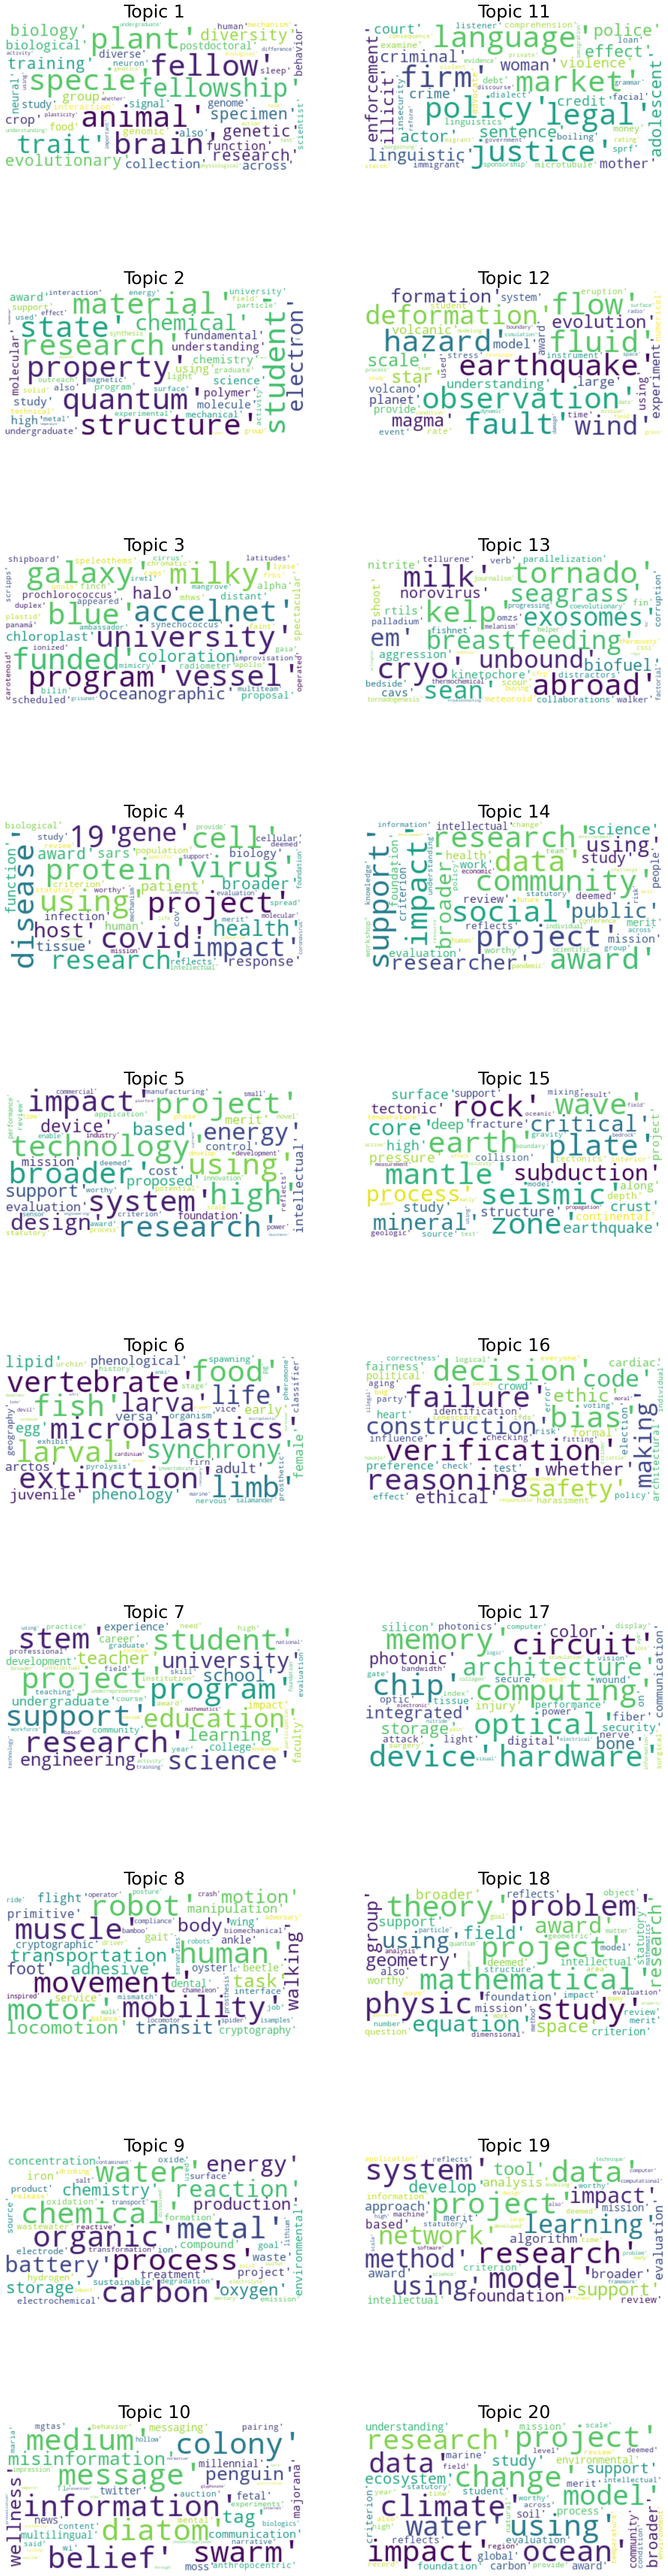

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud


fig,axes = plt.subplots(10, 2, figsize=(20, 80))

for i in range(10):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(generate_wordcloud(topic_word_freq[10*j + i]), interpolation="bilinear")
        ax.axis('off')
        ax.set_title(f"Topic {10*j + i + 1}", fontsize=30)

We'll reduce the dimensions of the topics to see them in a 2D graph.

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)



## Reference

* [Mercari Interactive EDA + Topic Modelling](https://www.kaggle.com/code/thykhuely/mercari-interactive-eda-topic-modelling)